In [1]:
# import required library
import os
import json
import time
import folium
import warnings
warnings.filterwarnings('ignore')  # ingore warning
import googlemaps
import numpy as np
import pandas as pd
import seaborn as sns
import haversine as hs
from haversine import Unit
from datetime import datetime
import openrouteservice as ors
import matplotlib.pyplot as plt
%matplotlib inline
from difflib import SequenceMatcher
from IPython.display import display
from pandas.io.json import json_normalize

In [2]:
# define the magic numbers
NULL_VALUE = -1
YES = 1
NO = 0

## Get API Keys

In [3]:
# read local openrouteservices api keys from txt
with open('../data/raw/APIkeys.txt') as file:
    api_keys = file.readlines()
    api_keys = [key.rstrip() for key in api_keys]

In [4]:
# read local googlemaps api keys from txt
with open('../data/raw/Google.txt') as file:
    google_api = file.readlines()
    google_api = [key.rstrip() for key in google_api]

## Merge Dataset

In [5]:
# read the dataset after data-cleaning
property_df = pd.read_csv('../data/curated/cleaned_property_data.csv', low_memory = False)
GNR = pd.read_csv('../data/curated/GNR_cleaned.csv', low_memory = False)
count_table = pd.read_csv('../data/curated/count_table.csv', low_memory = False)
count_dimension = pd.read_csv('../data/curated/count_dimension.csv', low_memory = False)

# read postcode match suburb
with open('../data/raw/postcode_match_suburb.json') as json_data:
    data = json.load(json_data)

# transfer json to dataframe 
postcode_match = pd.DataFrame.from_dict({'postcode':data.keys(), 'suburb':data.values()})
# make sure postcode are number
postcode_match['postcode'] = pd.to_numeric(postcode_match['postcode'])

In [6]:
# display all dataframe
display(property_df.head(10))
display(GNR.head(10))
display(postcode_match.head(10))
property_df.shape

,index,address,rent,features,type,furnitured,pool,gym,coordinates,desc,postcode,floor,num_bed,num_bath,num_car_park,rent_weekly
0,0,1414/218-228 A'Beckett Street Melbourne VIC 3000,$400 Per Week,1 Bed1 Bath− Parking,Apartment / Unit / Flat,No,No,No,"[-37.8102832, 144.9566691]",South Melbourne Leasing,3000,14,1,1,0,400
1,1,11a/131 Lonsdale Sreet Melbourne VIC 3000,$350 per week,1 Bed1 Bath− Parking,Studio,Yes,No,No,"[-37.810779, 144.9685513]",Wimpie Santoso,3000,11,1,1,0,350
2,2,911/408 Lonsdale Street Melbourne VIC 3000,$330 per week,1 Bed1 Bath− Parking,Apartment / Unit / Flat,No,No,No,"[-37.8125979, 144.9604012]",Ender Gok,3000,9,1,1,0,330
3,3,918/422 Collins St Melbourne VIC 3000,$600 Per week fully furnished,2 Beds1 Bath− Parking,Apartment / Unit / Flat,No,No,No,"[-37.8170971, 144.9601487]",Precinct Leasing,3000,9,2,1,0,600
4,4,602/118 Franklin Street Melbourne VIC 3000,$330,1 Bed1 Bath− Parking,Apartment / Unit / Flat,No,No,No,"[-37.8082052, 144.9589035]",Manuel Flores,3000,6,1,1,0,330
5,5,1112/333-351 Exhibition Street Melbourne VIC 3000,$600 per week,2 Beds2 Baths− Parking,Apartment / Unit / Flat,Yes,No,No,"[-37.80789559999999, 144.9682873]",Mark Faranda,3000,11,2,2,0,600
6,6,3002/288 Spencer St Melbourne VIC 3000,$510,2 Beds1 Bath1 Parking,Apartment / Unit / Flat,No,Yes,Yes,"[-37.813775, 144.9520948]",Leasing Team,3000,30,2,1,1,510
7,7,4/180 Little Collins Street Melbourne VIC 3000,$500 per week,1 Bed1 Bath− Parking,Apartment / Unit / Flat,Yes,No,No,"[-37.8138601, 144.9679067]",Trish Ha,3000,4,1,1,0,500
8,8,1605/565 Flinders Street Melbourne VIC 3000,$500 per week,2 Beds2 Baths1 Parking,Apartment / Unit / Flat,No,No,No,"[-37.8210586, 144.9559072]",Justine Muscat,3000,16,2,2,1,500
9,9,612/408 Lonsdale Street Melbourne VIC 3000,$350,1 Bed1 Bath− Parking,Apartment / Unit / Flat,Yes,No,No,"[-37.8125979, 144.9604012]",Manuel Flores,3000,6,1,1,0,350


,PLACE_NAME,FEATURE,LONGITUDE,LATITUDE,geometry,suburb,postcode
0,MOUNT CLEAR SECONDARY COLLEGE,SECONDARY SCHOOL,143.8766,-37.607,POINT (2400824.055420277 2431949.3066944666),MOUNT CLEAR,3357.0
1,VIEWBANK COLLEGE,SECONDARY SCHOOL,145.0865,-37.741,POINT (2507631.5373240355 2417744.9461323526),VIEWBANK,3084.0
2,Yarram Secondary College - Devon North Campus,SECONDARY SCHOOL,146.6478,-38.519,POINT (2643730.207553347 2330161.818601803),DEVON NORTH,NaN
3,Bass Coast College - San Remo Campus,SECONDARY SCHOOL,145.3905,-38.532,POINT (2534061.1052171467 2329809.2720654747),SAN REMO,3925.0
4,SANDRINGHAM SECONDARY COLLEGE BEAUMARIS CAMPUS,SECONDARY SCHOOL,145.0312,-37.978,POINT (2502746.435917485 2391445.676364539),BEAUMARIS,3193.0
5,SANDRINGHAM SECONDARY COLLEGE HIGHETT CAMPUS,SECONDARY SCHOOL,145.0212,-37.955,POINT (2501868.406406302 2393912.2221767586),SANDRINGHAM,3188.0
6,SANDRINGHAM SECONDARY COLLEGE SANDRINGHAM CAMPUS,SECONDARY SCHOOL,145.0254,-37.956,POINT (2502233.993617093 2393881.0541395023),SANDRINGHAM,3191.0
7,BEAUMARIS SECONDARY COLLEGE,SECONDARY SCHOOL,145.0340,-37.978,POINT (2502994.186749523 2391421.1723456345),BEAUMARIS,3193.0
8,PENOLA CATHOLIC COLLEGE,SECONDARY SCHOOL,144.9079,-37.709,POINT (2491880.327970704 2421254.8904169593),GLENROY,3041.0
9,SUNSHINE NORTH SECONDARY COLLEGE,SECONDARY SCHOOL,144.8434,-37.774,POINT (2486211.2802575794 2414064.5974380244),SUNSHINE NORTH,3020.0


,postcode,suburb
0,3000,[MELBOURNE]
1,3001,[MELBOURNE]
2,3002,[EAST MELBOURNE]
3,3003,[WEST MELBOURNE]
4,3004,"[MELBOURNE, ST KILDA ROAD CENTRAL, ST KILDA RO..."
5,3006,"[SOUTH WHARF, SOUTHBANK]"
6,3008,[DOCKLANDS]
7,3010,[UNIVERSITY OF MELBOURNE]
8,3011,"[FOOTSCRAY, SEDDON, SEDDON WEST]"
9,3012,"[BROOKLYN, KINGSVILLE, MAIDSTONE, TOTTENHAM, W..."


(14527, 16)

In [7]:
# show the all types of property data
property_df['type'].unique()

array(['Apartment / Unit / Flat', 'Studio', 'Townhouse', 'House', 'Villa',
       'New House & Land', 'Penthouse', 'Terrace', 'Semi-Detached',
       'Acreage / Semi-Rural', 'Duplex', 'New Apartments / Off the Plan',
       'Carspace', 'Retirement', 'Rural', 'Farm'], dtype=object)

In [8]:
# delete some unsusal data, treat them as outlier
property_df = property_df[property_df['type'] != 'Carspace']
property_df = property_df[property_df['type'] != 'Retirement']
property_df = property_df[property_df['type'] != 'Farm']
property_df = property_df[property_df['type'] != 'Acreage / Semi-Rural']
property_df = property_df[property_df['type'] != 'Rural']
property_df = property_df[property_df['type'] != 'New House & Land']

# re-classify the property data
property_df['type'] = property_df['type'].replace('Villa','House')
property_df['type'] = property_df['type'].replace('Semi-Detached','House')
property_df['type'] = property_df['type'].replace('Duplex','House')
property_df['type'] = property_df['type'].replace('New Apartments / Off the Plan','Apartment / Unit / Flat')
property_df['type'] = property_df['type'].replace('Terrace','Apartment / Unit / Flat')
property_df['type'] = property_df['type'].replace('Apartment / Unit / Flat', 'Apartment / Unit / Flat / Penhouse')
property_df['type'] = property_df['type'].replace('Penthouse', 'Apartment / Unit / Flat / Penhouse')
# reset index
property_df = property_df.reset_index(drop=True)

In [9]:
# Change to numerical
property_df = property_df.replace('-', NULL_VALUE)

property_df['furnitured'] = property_df['furnitured'].replace('Yes', YES)
property_df['furnitured'] = property_df['furnitured'].replace('No', NO)

property_df['pool'] = property_df['pool'].replace('Yes', YES)
property_df['pool'] = property_df['pool'].replace('No', NO)

property_df['gym'] = property_df['gym'].replace('Yes', YES)
property_df['gym'] = property_df['gym'].replace('No', NO)

In [10]:
def extract_suburb(address):
    '''Split the address and get the suburbs
    
    Args:
        address: the property address
    Return:
        suburb in address
    '''
    address = address.split(' ')
    if address[-3].isdigit():
        return address[-4]
    else:
        return address[-3]
# extract suburb from address
property_df['suburb'] = property_df['address'].apply(extract_suburb)

# make letter upper case
property_df['suburb'] = property_df['suburb'].str.upper()  

# make sure the postcodes are int
property_df['postcode'] = pd.to_numeric(property_df['postcode'])  

In [11]:
# select the feature we need
property_df = property_df[['address', 'rent_weekly', 'floor', 'suburb','postcode', 'type', 'furnitured', 'pool',
                           'gym', 'num_bed', 'num_bath', 'num_car_park', 'coordinates']].copy()

# convert coordinates from str to list
property_df['coordinates'] = property_df['coordinates'].apply(eval)

In [12]:
property_df.head(5)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,coordinates
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,1,0,"[-37.8102832, 144.9566691]"
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,3000,Studio,1,0,0,1,1,0,"[-37.810779, 144.9685513]"
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,1,0,"[-37.8125979, 144.9604012]"
3,918/422 Collins St Melbourne VIC 3000,600,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,1,0,"[-37.8170971, 144.9601487]"
4,602/118 Franklin Street Melbourne VIC 3000,330,6,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,1,0,"[-37.8082052, 144.9589035]"


In [13]:
def similar(a, b):
    '''Calculate the similarity percentage
    
    Args:
        a: standard suburb name
        b: suburb name from address
    Return:
        match ratio of a and b string
    '''
    return SequenceMatcher(None, a, b).ratio()

def most_similar(df,suburb):
    '''Find the most similar suburb
    
    Args:
        df: property dataframe
        suburb: standard suburb name
    Return:
        most matchable suburb name
    '''
    if df['suburb'].shape[0] == 1:
        current_match = [100,df['suburb'].iloc[0][0]]
    else:
        # initialize the most similar suburb
        current_match = [0,'None']
        # check similarity for each suburb
        for sub in df['suburb']:
            # get the similarity percentage
            simi_percent = similar(suburb, sub)
            # update most similar suburb
            if simi_percent > current_match[0]:
                current_match = [simi_percent, sub]
    # return the most similar suburb
    return current_match[1]


def correct_suburb(suburb_df, property_df):
    '''Find correct suburb
    
    Args:
        suburb_df: standard postcode suburb match dataframe
        property_df: property dataframe
    Return:
        property dataframe with correct suburb name
    '''
    # check property_df each row's suburb
    for row in range(property_df.shape[0]):
        # get the property postcode
        postcode = property_df.loc[row, 'postcode']
        # get the postcode and corresponding suburbs
        match_df = suburb_df[suburb_df['postcode'] == postcode]
        sub_lis = list(match_df['suburb'])[0]
        # if the suburb matched, don't change it
        if property_df.loc[row, 'suburb'] in sub_lis:
            pass
        # if the suburb don't matched, replace by the most similar suburb by postcode
        else:
            most_match = most_similar(match_df, property_df.loc[row, 'suburb'])
            property_df.at[row, 'suburb'] = most_match
    return property_df

In [14]:
# correct the suburb names in property data
property_df = correct_suburb(postcode_match,property_df)  

In [15]:
# merge count_table data and property_df
property_df = pd.merge(property_df, count_table, on='suburb', how='left').fillna(0)
property_df = pd.merge(property_df, count_dimension, on='suburb', how='left').fillna(0)

In [16]:
# save dataframe as df
property_df.to_csv('../data/curated/property_GNR.csv',index=False)

## Delete the Outlier

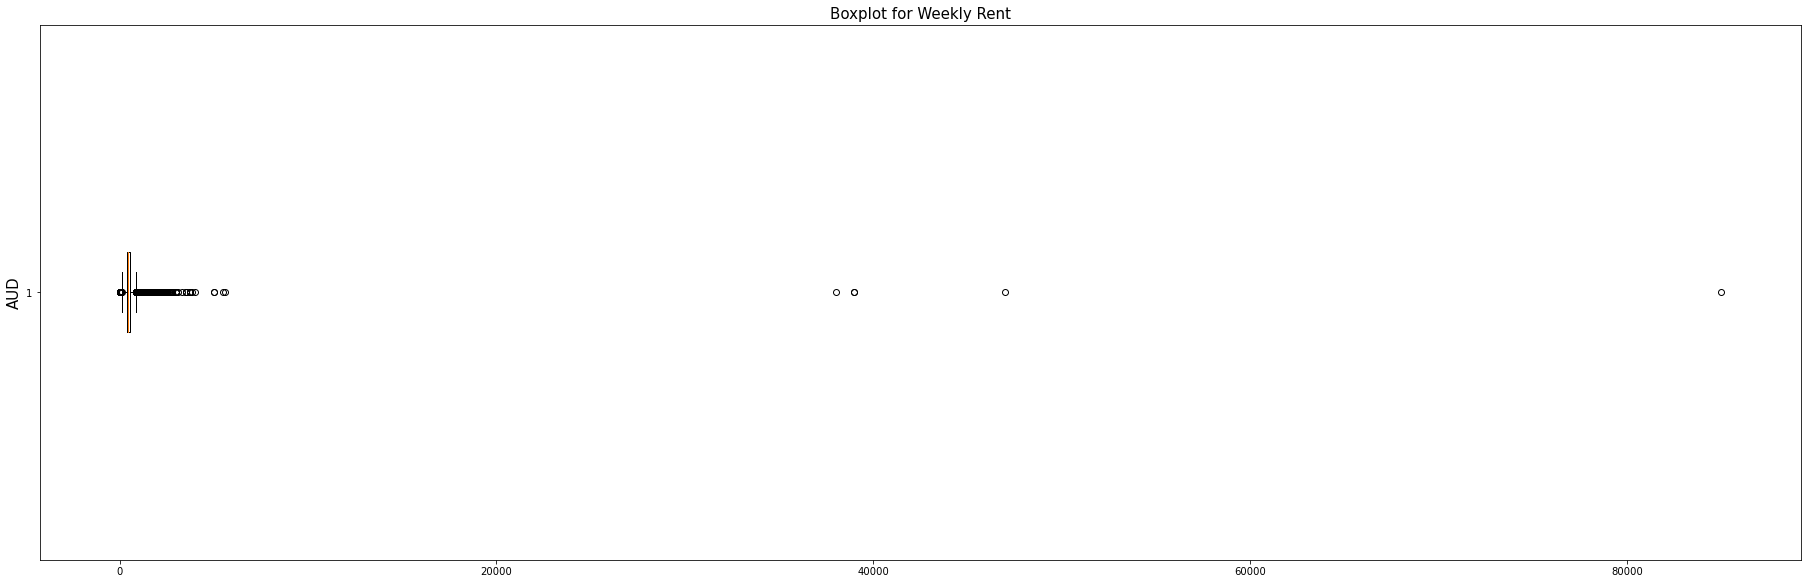

In [17]:
# Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(property_df['rent_weekly'], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel('AUD',fontsize=15)
plt.show()
# save figure
fig.figure.savefig('../plots/boxplot_before.png')

<AxesSubplot:title={'center':'weekly rent distribution'}, xlabel='rent_weekly', ylabel='Density'>

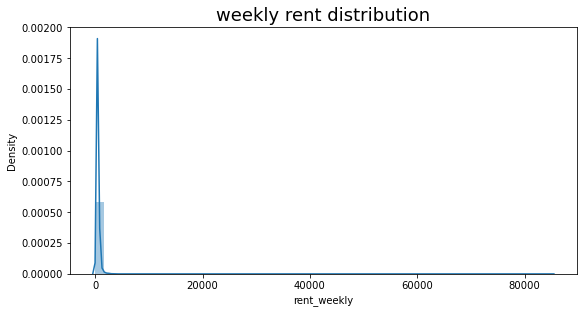

In [18]:
# plot the distribution plot to check the distribution
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution', fontsize=18)
sns.distplot(property_df['rent_weekly'])

In [19]:
# check the crusial values
property_df['rent_weekly'].describe()

count    14505.000000
mean       531.953326
std       1008.667255
min          1.000000
25%        385.000000
50%        450.000000
75%        570.000000
max      85000.000000
Name: rent_weekly, dtype: float64

In [20]:
# calculate Q1 and Q3 to calculate IQR
Q1 = property_df['rent_weekly'].quantile(0.25)
Q3 = property_df['rent_weekly'].quantile(0.75)
IQR = Q3 - Q1

# remove the outliers
property_df = property_df[~((property_df['rent_weekly'] < (Q1 - 1.5 * IQR)) | (property_df['rent_weekly'] > (Q3 + 1.5 * IQR)))]
property_df = property_df.reset_index(drop=True)  # reset index

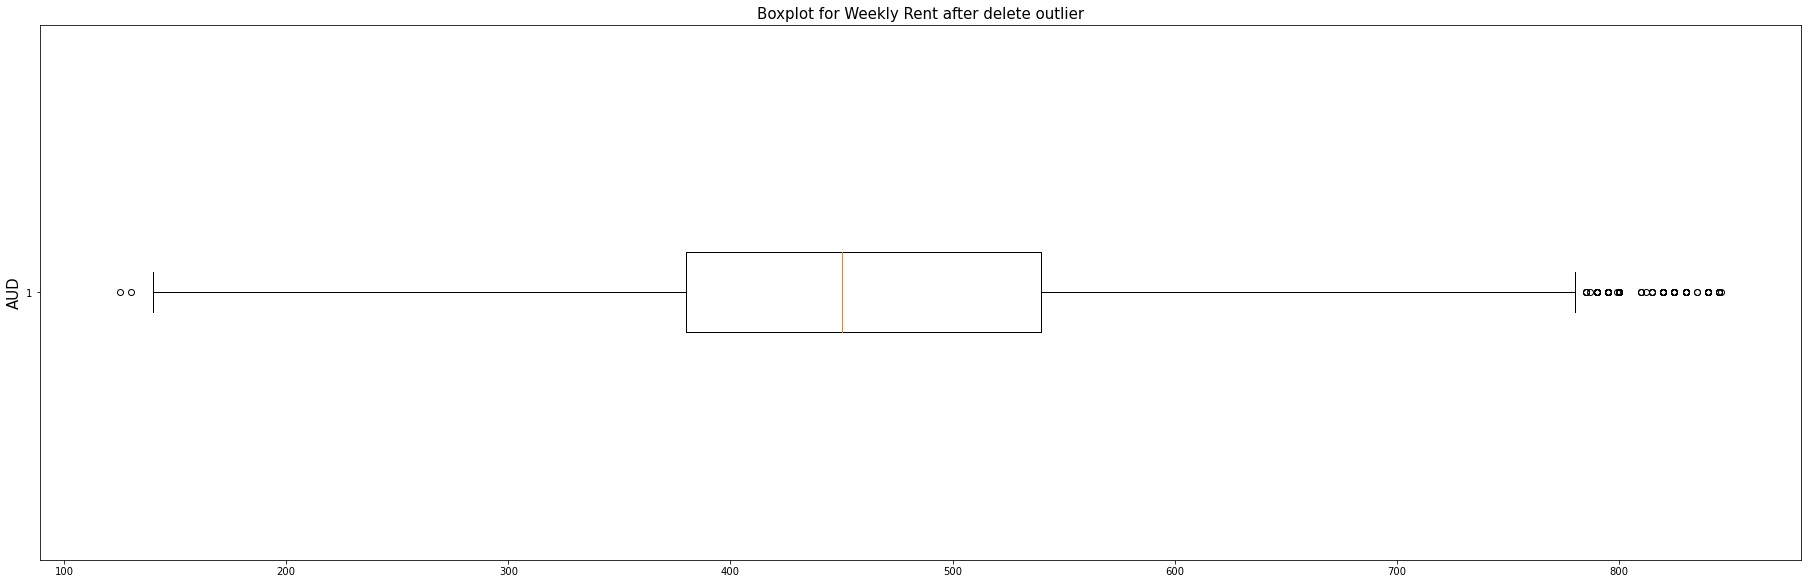

In [21]:
# Using Boxplot to find the outliers for numerical attributes again
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(property_df['rent_weekly'], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent after delete outlier',fontsize=15)
axs[0,0].set_ylabel('AUD',fontsize=15)
plt.show()
# save figure
fig.figure.savefig('../plots/boxplot_after.png')

<AxesSubplot:title={'center':'weekly rent distribution after delete outlier'}, xlabel='rent_weekly', ylabel='Density'>

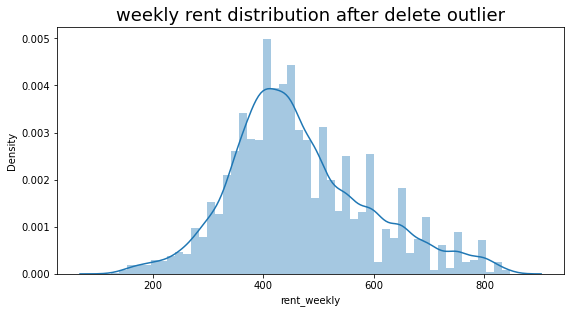

In [22]:
# plot the distribution figure again to check
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution after delete outlier', fontsize=18)
sns.distplot(property_df['rent_weekly'])

In [23]:
# check the crusial values again
property_df['rent_weekly'].describe()

count    13455.000000
mean       465.035823
std        126.035239
min        125.000000
25%        380.000000
50%        450.000000
75%        540.000000
max        846.000000
Name: rent_weekly, dtype: float64

In [24]:
# save dataframe as df
property_df.to_csv('../data/curated/property_GNR.csv',index=False)

## Calculate Distances Between Proerties and Features

In [25]:
# read in the dataset
property_df = pd.read_csv('../data/curated/property_GNR.csv', low_memory=False)
# convert string to dict
property_df['coordinates'] = property_df['coordinates'].apply(eval)

In [26]:
def around_1500m(loc, df):
    '''Check if the distance bewteen two points are smaller or equal to 1.5 km
    
    Args:
        loc: the coordinate of property
        df: point of interest dataframe
    Return:
        point of interest dataframe after filtered by distance
    '''
    # get the maximum and minimum longtitude and latitude
    max_long = loc[1] + 0.01
    min_long = loc[1] - 0.01
    max_lan = loc[0] + 0.01
    min_lan = loc[0] - 0.01
    
    # filter the point of interest by straight line distancce
    df = df[df['LONGITUDE'] <= max_long]
    df = df[df['LONGITUDE'] >= min_long]
    df = df[df['LATITUDE'] <= max_lan]
    df = df[df['LATITUDE'] >= min_lan]
    return df

# check if the distance bewteen two points are smaller or equal to 3 km
def around_3km(loc, df):
    '''Check if the distance bewteen two points are smaller or equal to 3 km
    
    Args:
        loc: the coordinate of property
        df: point of interest dataframe
    Return:
        point of interest dataframe after filtered by distance
    '''
    # get the maximum and minimum longtitude and latitude
    max_long = loc[1] + 0.02
    min_long = loc[1] - 0.02
    max_lan = loc[0] + 0.02
    min_lan = loc[0] - 0.02
    
    # filter the point of interest by straight line distancce
    df = df[df['LONGITUDE'] <= max_long]
    df = df[df['LONGITUDE'] >= min_long]
    df = df[df['LATITUDE'] <= max_lan]
    df = df[df['LATITUDE'] >= min_lan]
    return df

# check if the distance bewteen two points are smaller or equal to 10 km
def around_10km(loc, df):
    '''Check if the distance bewteen two points are smaller or equal to 10 km
    
    Args:
        loc: the coordinate of property
        df: point of interest dataframe
    Return:
        point of interest dataframe after filtered by distance
    '''
    # get the maximum and minimum longtitude and latitude
    max_long = loc[1] + 0.07
    min_long = loc[1] - 0.07
    max_lan = loc[0] + 0.07
    min_lan = loc[0] - 0.07

    # filter the point of interest by straight line distancce
    df = df[df['LONGITUDE'] <= max_long]
    df = df[df['LONGITUDE'] >= min_long]
    df = df[df['LATITUDE'] <= max_lan]
    df = df[df['LATITUDE'] >= min_lan]
    return df


def cloest_2point(dist_dict,dist,loc,stop):
    '''Comparing the distances and record two cloest points
    
    Args:
        dist_dict: a dict contains two cloest points
        dist: new distance
        loc: new coordinate
        stop: new point of interest name
    Return:
        a dict contains two cloest points
    '''
    # if there is no point, then just append the point into dict
    if len(dist_dict) < 2:
        dist_dict.append((dist,loc,stop))
    # if there already has two points, then compares distance
    else:
        # if the current distance smaller than records' distance
        if dist < dist_dict[0][0]:
            # delete the record point
            dist_dict.pop(0)
            # append new cloest point
            dist_dict.append((dist,loc,stop))
        elif dist < dist_dict[1][0]:
            # delete the record point
            dist_dict.pop(1)
            # append new cloest point
            dist_dict.append((dist,loc,stop))
    return dist_dict


def cloest_point(dist_dict,dist,loc,stop):
    '''Comparing the distances and record the most cloest points
    
    Args:
        dist_dict: a dict contains one cloest points
        dist: new distance
        loc: new coordinate
        stop: new point of interest name
    Return:
        a dict contains a cloest points
    '''
    # if there is no point, then just append the point into dict
    if len(dist_dict) < 1:
        dist_dict.append((dist,loc,stop))
    # if there already has three points, then compares distance
    else:
        # if the current distance smaller than records' distance
        if dist < dist_dict[0][0]:
            # delete the record point
            dist_dict.pop(0)
            # append new cloest point
            dist_dict.append((dist,loc,stop))
    return dist_dict
            

def distance_train(loc1):
    '''Calculate the cloest two train station for each property data
    
    Args:
        loc1: property coordinates
    Return:
        list that contains two cloest train station
    '''
    # read train station data
    GNR = pd.read_csv('../data/curated/GNR_cleaned.csv', low_memory = False)
    # initaliza the dict for record the cloest three point of interest
    dist_lis = []
    # read train station data
    train = GNR[GNR['FEATURE'] == 'TRAIN STATION']
    # filter train station within 10 km
    train = around_10km(loc1, train)
    
    # if there is not any train station within 10 km straight line distance, it should return empty list
    if train.shape[0] != 0:
        # find cloest two points
        for i in range(train.shape[0]):
            # feature points
            loc2 = (train.iloc[i]['LATITUDE'],train.iloc[i]['LONGITUDE'])
            # calculate distance between property and feature
            dist = hs.haversine(loc1,loc2,unit=Unit.METERS)
            # check the cloest
            dist_lis = cloest_2point(dist_lis,dist,loc2,train.iloc[i]['PLACE_NAME'])
    return dist_lis

# calculate the cloest three bus stop for each property data
def distance_bus(loc1):
    '''Calculate the cloest bus stop for each property data
    
    Args:
        loc1: property coordinates
    Return:
        list that contains one cloest bus stop
    '''
    # read train station data
    GNR = pd.read_csv('../data/curated/GNR_cleaned.csv', low_memory = False)
    # initaliza the dict for record the cloest three point of interest
    dist_lis = []
    # read train station data
    bus = GNR[GNR['FEATURE'] == 'BUS']
    # filter bus stop within 1.5 km
    bus = around_1500m(loc1, bus)
    # if there is not any bus stop within 1.5 km straight line distance, it should return empty list
    if bus.shape[0] == 0:
        dist_lis = []
    else:
        # find cloest point
        for i in range(bus.shape[0]):
            # feature points
            loc2 = (bus.iloc[i]['LATITUDE'],bus.iloc[i]['LONGITUDE'])
            # calculate distance between property and feature
            dist = hs.haversine(loc1,loc2,unit=Unit.METERS)
            # check the cloest
            dist_lis = cloest_point(dist_lis,dist,loc2,bus.iloc[i]['PLACE_NAME'])
    return dist_lis

# calculate the cloest three tram stop for each property data
def distance_tram(loc1):
    '''Calculate the cloest tram stop for each property data
    
    Args:
        loc1: property coordinates
    Return:
        list that contains one cloest tram stop
    '''
    # read train station data
    GNR = pd.read_csv('../data/curated/GNR_cleaned.csv', low_memory = False)
    # initaliza the dict for record the cloest three point of interest
    dist_lis = []
    # read train station data
    tram = GNR[GNR['FEATURE'] == 'TRAM STATION']
    # filter tram stop within 3 km
    tram = around_3km(loc1, tram)
    # if there is not any bus stop within 3 km straight line distance, it should return empty list
    if tram.shape[0] == 0:
        dist_lis = []
    else:
        # find cloest point
        for i in range(tram.shape[0]):
            # feature points
            loc2 = (tram.iloc[i]['LATITUDE'],tram.iloc[i]['LONGITUDE'])
            # calculate distance between property and feature
            dist = hs.haversine(loc1,loc2,unit=Unit.METERS)
            # check the cloest
            dist_lis = cloest_point(dist_lis,dist,loc2,tram.iloc[i]['PLACE_NAME'])
    return dist_lis


def distance_GNR(loc1):
    '''Find the cloest school, park, supermarket and etc
    
    Args:
        loc1: property coordinates
    Return:
        property dataframe with all cloest point of interest
    '''
    # read data in
    GNR = pd.read_csv('../data/curated/GNR_cleaned.csv', low_memory = False)
    # delete train
    GNR = GNR[GNR['FEATURE']!= 'TRAIN STATION']
    
    # get all feature types
    feature = ['cloest_' + s for s in list(GNR['FEATURE'].unique())]
    # record the cloest distance and place and duration
    dist_GNR = {}
    # find the cloest point of interest
    for i in range(len(feature)):
        
        # select the feature type
        temp_df = GNR[GNR['FEATURE'] == list(GNR['FEATURE'].unique())[i]].copy()
        dist_lis = []
        if 'TRAM' in feature[i]:
            temp_df = around_3km(loc1, temp_df)
        elif 'BUS'in feature[i]:
            temp_df = around_1500m(loc1, temp_df)
            
        # find cloest feature
        for j in range(temp_df.shape[0]):
            loc2 = (temp_df.iloc[j]['LATITUDE'],temp_df.iloc[j]['LONGITUDE'])
            # calculate distance between property and feature
            dist = hs.haversine(loc1,loc2,unit=Unit.METERS)
            # check the cloest
            dist_lis = cloest_point(dist_lis,dist,loc2,temp_df.iloc[j]['PLACE_NAME'])
            dist_GNR[feature[i]] = dist_lis
            
    return dist_GNR


def extract_cloest(df):
    '''Extract the each cloest point of interest 
    
    Args:
        df: property dataframe
    Return:
        property dataframe with cloest point of interest 
    '''
    GNR = pd.read_csv('../data/curated/GNR.csv', low_memory=False)
    # get the columns'name
    feature_lis = ['cloest_' + s for s in list(GNR['FEATURE'].unique())]
    # delete column name about train, tram and bus
    feature_lis = [x for x in feature_lis if ('TRAIN STATION' not in x)]
    # unzip all the features
    for feature in feature_lis:
        df[feature] = np.nan
        # upzip each row
        for row in range(df.shape[0]):
            try:
                dist = df.loc[row, 'GNR'][feature][0][0]
            except Exception as e:
                print(e)
                dist = NULL_VALUE
            df.at[row, feature] = dist
    return df

In [27]:
# get the current time
start=datetime.now()
# find the cloest train station
property_df['cloest_train_station'] = property_df['coordinates'].apply(distance_train)
# print processing time
print(datetime.now()-start)

0:15:21.199413


In [ ]:
# get the current time
start=datetime.now()
# find the cloest train station
property_df['GNR'] = property_df['coordinates'].apply(distance_GNR)
# print processing time
print(datetime.now()-start)

In [ ]:
# save the data
property_df.to_csv('../data/curated/final_property.csv',index=False)

In [ ]:
# extract all the cloest point of interest 
property_df = extract_cloest(property_df)
property_df = property_df.drop(columns=['GNR'])

In [ ]:
property_df

In [ ]:
# save the data
property_df.to_csv('../data/curated/property_cleaned.csv',index=False)

## Find the cloest point

In [2]:
# read in the dataset
property_df = pd.read_csv('../data/curated/property_cleaned.csv', low_memory=False)
# tranfer the string to the origin data type
property_df['coordinates'] = property_df['coordinates'].apply(eval)
property_df['cloest_train_station'] = property_df['cloest_train_station'].apply(eval)

In [3]:
# put two coordinate in and return the duration between two coordinates
# coordinate form [longitude, latitude]
def calculate_distance_between_coordinates(coordinate1, coordinate2, api_key):
    '''Calculate driving time
    
    Args:
        coordinate1: property coordinate
        coordinate2: point of interest coordinate
        api_key: openrouteservices api key
    Return:
        distance and duration
    '''

    # connect open route service
    client = ors.Client(key = api_key)

    # put two coordinates in list
    cor = [(coordinate1[1],coordinate1[0]), (coordinate2[1],coordinate2[0])]

    # using open route service
    route = client.directions(
    coordinates= cor,
    profile='driving-car',
    format='geojson',
    )
    
    # set the sleep time
    time.sleep(1.5)

    # dict of distance and duration
    dist = route['features'][0]['properties']['segments'][0]['distance']
    duration = route['features'][0]['properties']['segments'][0]['duration']
    
    # return the duration
    return dist, duration

In [4]:
# function help to find the travel distance, name, duration
def find_driving(coor,lis,api_key):
    '''Find the travel distance, name, duration
    
    Args:
        coor: property coordinate
        lis: cloest point of interest list
        api_key: openrouteservices api key
    Return:
        dict contain cloest point's driving distance, time and name
    '''
    result ={'dist':[],'name':[],'duration':[]}
    
    if len(lis) > 0:
        # first point
        dist, duration = calculate_distance_between_coordinates(coor,lis[0][1],api_key)
        result['dist'].append(dist)
        result['name'].append(lis[0][2])
        result['duration'].append(duration)
        
        
        if len(lis) > 1:
            # second point
            dist, duration = calculate_distance_between_coordinates(coor,lis[1][1],api_key)
            result['dist'].append(dist)
            result['name'].append(lis[1][2])
            result['duration'].append(duration)

    return result

In [5]:
# function to find the transportation time
def transportation_time(df,api):
    '''Find the transportation time
    
    Args:
        df: property dataframe
        api: openrouteservices api key
    Return:
        property dataframe with cloest train station driving information
    '''
    df['cloest_TRAIN_STATION'] = np.nan
    df['cloest_TRAIN_STATION_duration'] = np.nan
    df['cloest_TRAIN_STATION_distance'] = np.nan
    result = find_driving(df['coordinates'],df['cloest_train_station'],api)
    
    # for the lenght of duration bigger than 1
    if len(result['duration']) > 1:
        if result['duration'][0] > result['duration'][1]:
            idx = 1
        else:
            idx = 0
        df['cloest_TRAIN_STATION'] = result['name'][idx]
        df['cloest_TRAIN_STATION_duration'] = result['duration'][idx]
        df['cloest_TRAIN_STATION_distance'] = result['dist'][idx]
    
    # for the lenght of duration is equal to 1
    elif len(result['duration']) == 1:
        idx = 0
        df['cloest_TRAIN_STATION'] = result['name'][idx]
        df['cloest_TRAIN_STATION_duration'] = result['duration'][idx]
        df['cloest_TRAIN_STATION_distance'] = result['dist'][idx]

    else:
        df['cloest_TRAIN_STATION'] = NULL_VALUE
        df['cloest_TRAIN_STATION_duration'] = NULL_VALUE
        df['cloest_TRAIN_STATION_distance'] = NULL_VALUE

    return df

In [6]:
# function to find the shortest train station
def find_shortest(lis):
    '''find the train station with shortest driving time
    
    Args:
        lis: property dataframe
    Return:
        property dataframe with closest train station
    '''
    lis['cloest_TRAIN_STATION'] = np.nan
    lis['cloest_TRAIN_STATION_duration'] = np.nan
    lis['cloest_TRAIN_STATION_distance'] = np.nan
    
    # if length of the list is greater than 1, then need ti compare
    if len(lis['cloest_train_station']) > 1:
        if lis['cloest_train_station'][0][0] > lis['cloest_train_station'][1][0]:
            result = lis['cloest_train_station'][1]
        else:
            result = lis['cloest_train_station'][0]
    # otherwise result is itself
    else:
        result = lis['cloest_train_station'][0]
    
    lis['cloest_TRAIN_STATION'] = result[2]
    lis['cloest_TRAIN_STATION_duration'] = np.nan
    lis['cloest_TRAIN_STATION_distance'] = result[0]
    return lis

In [ ]:
# reverse the coordinates by small size due to request limitation
df = pd.DataFrame(columns = property_df.columns)  # create a new dataframe with same columns as property dataframe
# row index of property dataframe
i = 0
# key index of api keys
key = 0
# calculate each row's driving time
while i < property_df.shape[0] and key < 16:
    # get each row
    df_i = property_df.iloc[i].copy()
    try:
        # calculate driving time
        df_i = transportation_time(df_i,api_keys[key])
        # convert series to dataframe
        df_i = df_i.to_frame().transpose()
        # add to main dataframe
        df = pd.concat([df ,df_i],ignore_index=True)
        i+=1
    # if there is any api error
    except ors.exceptions.ApiError as err:
        # if quota excess, change api key
        if 'Quota exceeded' in str(err):
            # if it is last key, return to first key
            if key == 15:
                key = 0
            else:
                key += 1
            print('Current i: ', i, ' ; Update Key: ', key)
        # if it is radius error, return straight line distance    
        elif 'Could not find routable point within a radius of 350.0 meters of specified coordinate' in str(err):
            df_i = find_shortest(df_i)
            df_i = df_i.to_frame().transpose()
            df = pd.concat([df ,df_i],ignore_index=True)
            i+=1
        else:
            print(err)
    # print processing
    if i % 1000 == 0:
        print('DONE ROW ',i)

In [ ]:
df

In [ ]:
# save the data
df.to_csv('../data/curated/data.csv',index=False)